# Load data

In [5]:
import pandas as pd
from pathlib import Path

base_folder = Path.cwd()


sample_files = ['sample_1.csv', 'sample_2.csv', 'sample_3.csv', 'sample_4.csv']
data = {}

for folder in [f for f in base_folder.iterdir() if f.is_dir()]:
    data[folder.name] = {}
    for sample_file in sample_files:
        file_path = folder / sample_file
        if file_path.exists():
            df = pd.read_csv(file_path, encoding='utf-8-sig')  # handles BOM if present
            # Normalize column names: strip spaces and BOM, unify case
            df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=True)
            data[folder.name][sample_file] = df


# Containers for data and weights
data = {}
weights = {}

# Helper function to read weights.txt into a dictionary
def read_weights(file_path):
    w = {}
    with open(file_path, 'r') as f:
        for line in f:
            if ";" in line:
                key, value = line.strip().split(";")
                key = key.strip().lower().replace("sample", "sample_") + ".csv"
                value = float(value.strip().replace("grams", "").strip())
                w[key] = value
    return w

# First, load healthy dataset weights for delta comparison
healthy_folder = base_folder / "healthydataset"
healthy_weights = read_weights(healthy_folder / "weights.txt")

# Now process all folders
for folder in [f for f in base_folder.iterdir() if f.is_dir()]:
    folder_name = folder.name
    data[folder_name] = {}
    weights[folder_name] = {}
    
    # Read weights
    weight_file = folder / "weights.txt"
    if weight_file.exists():
        current_weights = read_weights(weight_file)
        for sample_file in sample_files:
            if sample_file in current_weights:
                delta = current_weights[sample_file] - healthy_weights.get(sample_file, 0.0)
                weights[folder_name][sample_file] = delta
    
    # Read sample data
    for sample_file in sample_files:
        file_path = folder / sample_file
        if file_path.exists():
            df = pd.read_csv(file_path, encoding='utf-8-sig')
            df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=True)
            data[folder_name][sample_file] = df


# PLOT DATA

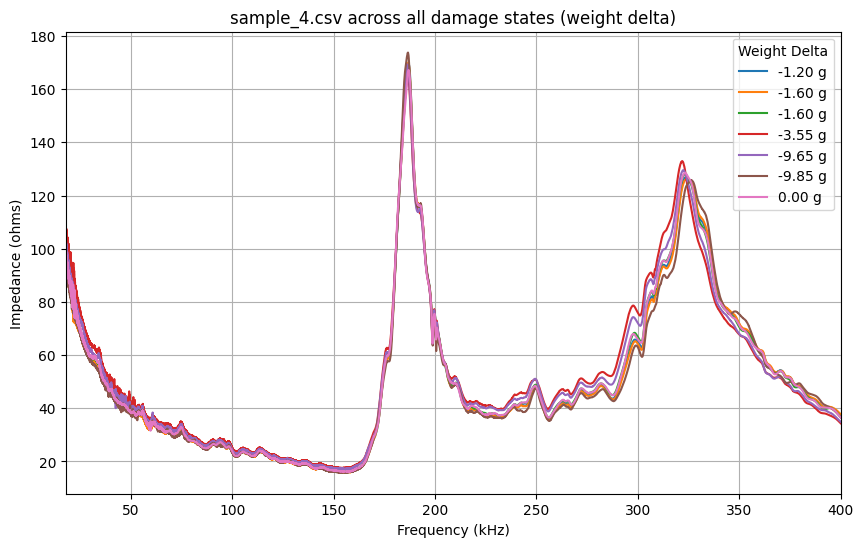

In [7]:
import matplotlib.pyplot as plt

sample_to_plot = "sample_4.csv"

plt.figure(figsize=(10, 6))

for folder_name, samples in data.items():
    if sample_to_plot in samples:
        df = samples[sample_to_plot]
        # Get the delta weight label, format nicely (e.g. 2 decimals)
        delta_weight = weights.get(folder_name, {}).get(sample_to_plot, None)
        label = f"{delta_weight:.2f} g" if delta_weight is not None else folder_name
        
        plt.plot(
            df["Frequency (Hz)"]/1000,
            df["Impedance (ohms)"],
            label=label
        )

plt.xlabel("Frequency (kHz)")
plt.ylabel("Impedance (ohms)")
plt.title(f"{sample_to_plot} across all damage states (weight delta)")
plt.legend(title="Weight Delta")
plt.grid(True)
plt.xlim(18,400)
plt.show()


# PLOT EQUIVALENT CIRCUIT

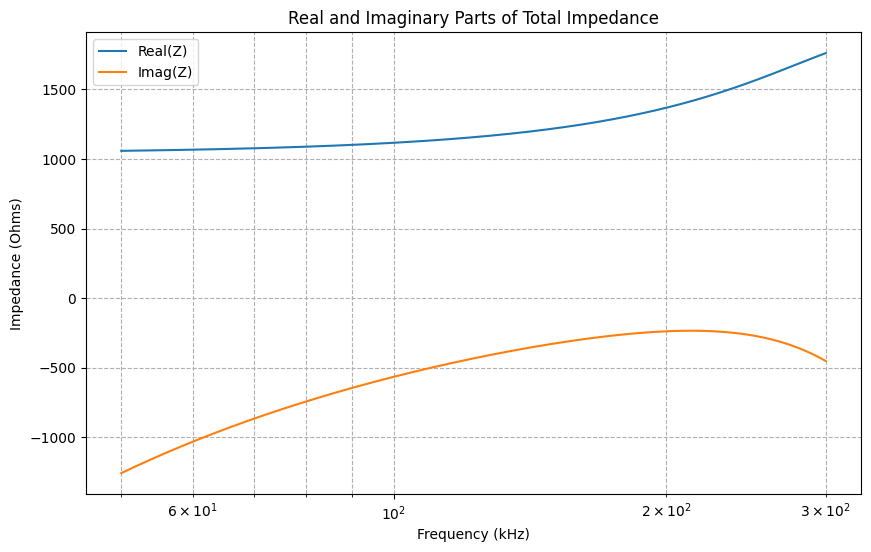

In [ ]:
import numpy as np

# Component values
C0 = 260.38e-12  # pFarads
L1 = 587.63e-6  # uHenrys
C1 = 2.18e-9  # nFarads
R1 = 1302     # Ohms

# Frequency range
start_freq = 50_000   # 50 kHz
end_freq = 300_000    # 400 kHz
num_points = 500

f = np.logspace(np.log10(start_freq), np.log10(end_freq), num_points)

omega = 2 * np.pi * f

# Impedances
Z_C0 = 1 / (1j * omega * C0)
Z_series = R1 + 1j * omega * L1 - 1j / (omega * C1)

# Total impedance of parallel combination
Z_total = 1 / (1 / Z_C0 + 1 / Z_series)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(f/1000, Z_total.real, label='Real(Z)')
plt.plot(f/1000, Z_total.imag, label='Imag(Z)')
plt.xscale('log')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Impedance (Ohms)')
plt.title('Real and Imaginary Parts of Total Impedance')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()


# First fit attempt

Fitted parameters (band):
C0 = 3.1306e-09 F
L1 = 2.8844e-03 H
C1 = 1.8709e-06 F
R1 = 36.4752 Ω


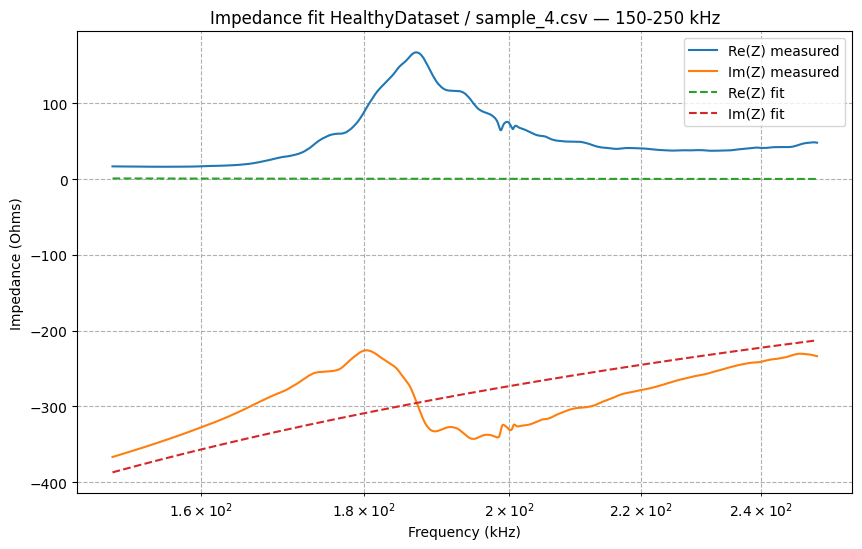

RMSE Real: 6.5563e+01 Ω
RMSE Imag: 4.2412e+01 Ω
R² Real: -2.2223
R² Imag: -0.1762


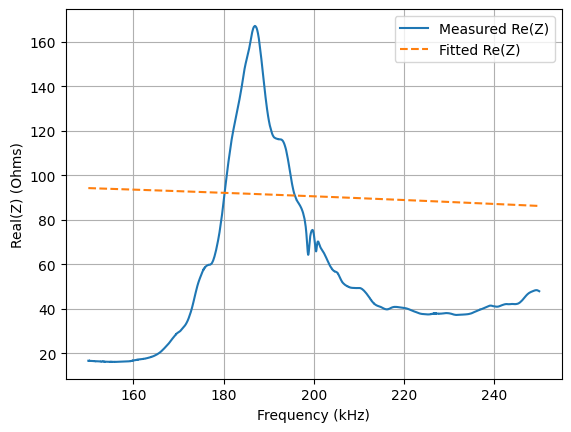

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# ----- Circuit model -----
def impedance_model(f, C0, L1, C1, R1):
    w = 2 * np.pi * f
    Z_C0 = 1.0 / (1j * w * C0)
    Z_series = R1 + 1j * w * L1 - 1j / (w * C1)
    Z_total = 1.0 / (1.0 / Z_C0 + 1.0 / Z_series)
    return Z_total

# ----- Residual builders -----
def residuals_complex(params, f, Z_meas, weights=None):
    Z_pred = impedance_model(f, *params)
    r = np.concatenate([(Z_pred.real - Z_meas.real), (Z_pred.imag - Z_meas.imag)])
    if weights is not None:
        r[:len(f)] *= weights
        r[len(f):] *= weights
    return r

def residuals_magnitude(params, f, Zmag_meas, weights=None):
    Z_pred = impedance_model(f, *params)
    r = np.abs(Z_pred) - Zmag_meas
    if weights is not None:
        r *= weights
    return r

# ----- Parse impedance from DF -----
def get_frequency_and_impedance(df):
    f = df["Frequency (Hz)"].to_numpy(dtype=float)
    Re = df["Impedance (ohms)"].to_numpy(dtype=float)  # Real part
    Im = df["Phase (Radians)"].to_numpy(dtype=float)   # Imaginary part (mislabeled)
    Z = Re + 1j * Im
    return f, Z, None

import numpy as np

def fit_quality_metrics(f, Z_meas, Z_fit):
    err_real = Z_fit.real - Z_meas.real
    err_imag = Z_fit.imag - Z_meas.imag
    
    rmse_real = np.sqrt(np.mean(err_real**2))
    rmse_imag = np.sqrt(np.mean(err_imag**2))
    
    print(f"RMSE Real: {rmse_real:.4e} Ω")
    print(f"RMSE Imag: {rmse_imag:.4e} Ω")

    # Optional: correlation coefficient (R²) for real and imag
    def r2(y_true, y_pred):
        ss_res = np.sum((y_true - y_pred)**2)
        ss_tot = np.sum((y_true - np.mean(y_true))**2)
        return 1 - ss_res/ss_tot
    
    r2_real = r2(Z_meas.real, Z_fit.real)
    r2_imag = r2(Z_meas.imag, Z_fit.imag)
    print(f"R² Real: {r2_real:.4f}")
    print(f"R² Imag: {r2_imag:.4f}")

def residuals_real(params, f, Z_meas_real, weights=None):
    Z_pred = impedance_model(f, *params)
    r = Z_pred.real - Z_meas_real
    if weights is not None:
        r *= weights
    return r

def fit_impedance_real(f, Z_meas_real, p0, bounds, weights=None, verbose=False):
    res = least_squares(
        residuals_real, x0=np.array(p0, dtype=float),
        bounds=bounds, args=(f, Z_meas_real, weights),
        jac="2-point", max_nfev=2000, xtol=1e-12, ftol=1e-12, gtol=1e-12,
        verbose=2 if verbose else 0
    )
    popt = res.x
    Z_fit = impedance_model(f, *popt)
    return popt, Z_fit, res



# ----- Fit one trace -----
def fit_impedance(f, Z_meas=None, Zmag_meas=None,
                  p0=(260.38e-12, 587.63e-6, 2.18e-9, 1302.0),
                  bounds=((1e-13, 1e-7, 1e-10, 1.0), (1e-9, 5e-3, 1e-6, 1e6)),
                  weights=None, verbose=False):
    if Z_meas is not None:
        res = least_squares(
            residuals_complex, x0=np.array(p0, dtype=float),
            bounds=bounds, args=(f, Z_meas, weights),
            jac="2-point", max_nfev=2000, xtol=1e-12, ftol=1e-12, gtol=1e-12,
            verbose=2 if verbose else 0
        )
    elif Zmag_meas is not None:
        res = least_squares(
            residuals_magnitude, x0=np.array(p0, dtype=float),
            bounds=bounds, args=(f, Zmag_meas, weights),
            jac="2-point", max_nfev=2000, xtol=1e-12, ftol=1e-12, gtol=1e-12,
            verbose=2 if verbose else 0
        )
    else:
        raise ValueError("Provide either Z_meas or Zmag_meas.")

    popt = res.x
    Z_fit = impedance_model(f, *popt)
    return popt, Z_fit, res

# ----- Plot helper -----
def plot_fit(f, Z_meas=None, Zmag_meas=None, Z_fit=None, title_suffix=""):
    plt.figure(figsize=(10, 6))
    plt.xscale("log")
    if Z_meas is not None:
        plt.plot(f/1e3, Z_meas.real, label="Re(Z) measured")
        plt.plot(f/1e3, Z_meas.imag, label="Im(Z) measured")
        if Z_fit is not None:
            plt.plot(f/1e3, Z_fit.real, '--', label="Re(Z) fit")
            plt.plot(f/1e3, Z_fit.imag, '--', label="Im(Z) fit")
        ylabel = "Impedance (Ohms)"
    else:
        plt.plot(f/1e3, Zmag_meas, label="|Z| measured")
        if Z_fit is not None:
            plt.plot(f/1e3, np.abs(Z_fit), '--', label="|Z| fit")
        ylabel = "|Z| (Ohms)"
    plt.xlabel("Frequency (kHz)")
    plt.ylabel(ylabel)
    plt.title(f"Impedance fit {title_suffix}")
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()

# ===== Example usage =====
folder_name = "HealthyDataset"
sample_to_fit = "sample_4.csv"
folder_key = folder_name  # adjust if you use safe lookup

df = data[folder_key][sample_to_fit]
f, Z_meas, Zmag_meas = get_frequency_and_impedance(df)

# ---- Parameters & band selection ----
p0 = (250e-12, 500e-6, 2e-9, 1000.0)
bounds = ((1e-15, 1e-9, 1e-12, 1e-3),
          (1e-6, 1e-2, 1e-4, 1e8))
w = None

fmin = 150e3
fmax = 250e3
mask = (f >= fmin) & (f <= fmax)
f_band = f[mask]
if Z_meas is not None:
    Z_meas_band = Z_meas[mask]
    Zmag_meas_band = None
else:
    Z_meas_band = None
    Zmag_meas_band = Zmag_meas[mask]

# ---- Fit only selected band ----
popt, Z_fit_band, result = fit_impedance(
    f_band,
    Z_meas=Z_meas_band,
    Zmag_meas=Zmag_meas_band,
    p0=p0,
    bounds=bounds,
    weights=w,
    verbose=False
)

# ---- Report ----
C0_fit, L1_fit, C1_fit, R1_fit = popt
print("Fitted parameters (band):")
print(f"C0 = {C0_fit:.4e} F")
print(f"L1 = {L1_fit:.4e} H")
print(f"C1 = {C1_fit:.4e} F")
print(f"R1 = {R1_fit:.6g} Ω")

plot_fit(f_band, Z_meas=Z_meas_band, Zmag_meas=Zmag_meas_band,
         Z_fit=Z_fit_band,
         title_suffix=f"{folder_key} / {sample_to_fit} — {fmin/1e3:.0f}-{fmax/1e3:.0f} kHz")

# After fitting and plotting call:
fit_quality_metrics(f, Z_meas_band, Z_fit_band)

popt, Z_fit, result = fit_impedance_real(f_band, Z_meas_band.real, p0, bounds, weights=w)

plt.figure()
plt.plot(f_band/1e3, Z_meas_band.real, label='Measured Re(Z)')
plt.plot(f_band/1e3, Z_fit.real, '--', label='Fitted Re(Z)')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Real(Z) (Ohms)')
plt.legend()
plt.grid(True)
plt.show()



# Self plotting

Chosen L1 = 38763.000 uH, C1 = 218000.00 nF, C0 = 0.00 nF


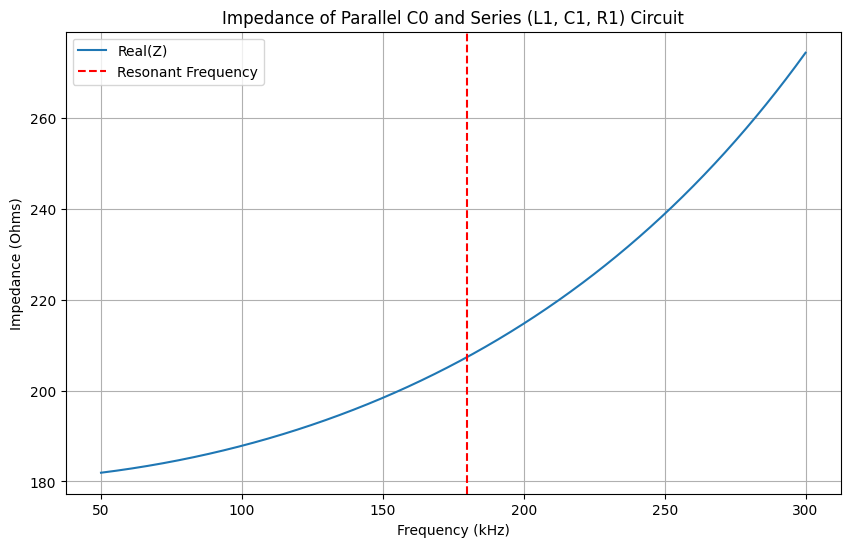

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Given specs
f_resonant = 180e3  # 180 kHz
# Component values
C0 = 1.38e-12  # pFarads
L1 = 387.63e-4  # uHenrys
C1 = 2.18e-4  # nFarads
R1 = 180     # Ohms

print(f"Chosen L1 = {L1*1e6:.3f} uH, C1 = {C1*1e9:.2f} nF, C0 = {C0*1e9:.2f} nF")

# Frequency range for plotting
f = np.linspace(50e3, 300e3, 1000)  # 50kHz to 300kHz
omega = 2 * np.pi * f

# Impedances
Z_C0 = 1 / (1j * omega * C0)

Z_series = R1 + 1j * omega * L1 + 1 / (1j * omega * C1)

# Total impedance: parallel combination
Z_total = 1 / (1/Z_C0 + 1/Z_series)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(f/1e3, Z_total.real, label='Real(Z)')
#plt.plot(f/1e3, Z_total.imag, label='Imag(Z)')
plt.axvline(f_resonant/1e3, color='red', linestyle='--', label='Resonant Frequency')
plt.title('Impedance of Parallel C0 and Series (L1, C1, R1) Circuit')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Impedance (Ohms)')
plt.grid(True)
plt.legend()
plt.show()


Maximum Q = 49121.90 at:
C1 = 0.1000 pF
L1 = 7817992.5650 uH
Fixed R1 = 180 Ohms, Resonant freq = 180.0 kHz


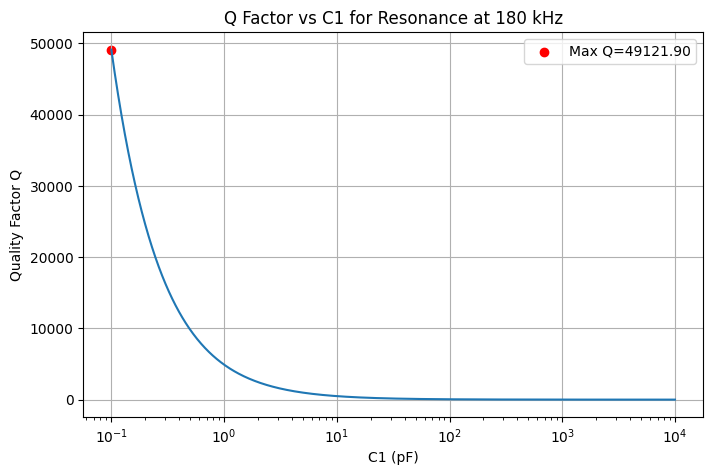

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Given constants
f_resonant = 180e3  # Hz
R1 = 180  # Ohms
C0 = 1.38e-9  # Fixed parallel capacitor (F)

# Resonant frequency omega0
omega0 = 2 * np.pi * f_resonant

# Sweep C1 from 0.1 pF to 10 nF logarithmically
C1_values = np.logspace(-13, -8, 1000)  # in Farads

# Calculate corresponding L1 to maintain resonance
L1_values = 1 / (omega0**2 * C1_values)

# Calculate Q factor for each
Q_values = (1 / R1) * np.sqrt(L1_values / C1_values)  # or Q = 1/(R1) * 1/(omega0 * C1)

# Find max Q and corresponding components
max_idx = np.argmax(Q_values)
max_Q = Q_values[max_idx]
best_C1 = C1_values[max_idx]
best_L1 = L1_values[max_idx]

print(f"Maximum Q = {max_Q:.2f} at:")
print(f"C1 = {best_C1*1e12:.4f} pF")
print(f"L1 = {best_L1*1e6:.4f} uH")
print(f"Fixed R1 = {R1} Ohms, Resonant freq = {f_resonant/1e3} kHz")

# Plot Q vs C1
plt.figure(figsize=(8,5))
plt.semilogx(C1_values*1e12, Q_values)
plt.scatter(best_C1*1e12, max_Q, color='red', label=f'Max Q={max_Q:.2f}')
plt.xlabel('C1 (pF)')
plt.ylabel('Quality Factor Q')
plt.title('Q Factor vs C1 for Resonance at 180 kHz')
plt.grid(True)
plt.legend()
plt.show()


In [76]:
import numpy as np

# Assume f_band and Z_meas_band.real are numpy arrays

def estimate_q_factor(f_band, Z_real):
    peak_idx = np.argmax(Z_real)
    f0 = f_band[peak_idx]
    peak_val = Z_real[peak_idx]
    half_power = peak_val / np.sqrt(2)
    
    # Find lower frequency at half power
    lower_idx = np.where(Z_real[:peak_idx] <= half_power)[0]
    if len(lower_idx) == 0:
        f1 = f_band[0]
    else:
        f1 = f_band[lower_idx[-1]]
    
    # Find higher frequency at half power
    upper_idx = np.where(Z_real[peak_idx:] <= half_power)[0]
    if len(upper_idx) == 0:
        f2 = f_band[-1]
    else:
        f2 = f_band[peak_idx + upper_idx[0]]
    
    bandwidth = f2 - f1
    Q = f0 / bandwidth if bandwidth != 0 else np.inf
    
    print(f"Resonant frequency f0 = {f0/1e3:.2f} kHz")
    print(f"Bandwidth Δf = {bandwidth/1e3:.2f} kHz")
    print(f"Estimated Q factor = {Q:.2f}")
    return Q

# Example usage:
Q = estimate_q_factor(f_band, Z_meas_band.real)


Resonant frequency f0 = 186.97 kHz
Bandwidth Δf = 8.91 kHz
Estimated Q factor = 20.98


In [81]:
import numpy as np
from scipy.optimize import least_squares

# Expect: f (Hz), Z_meas (complex ndarray, same length)
def fit_C0_parallel_series_RLC(f, Z_meas, seeds=None, bounds=None, logparam=True):

    w = 2*np.pi*f
    Y_meas = 1.0 / Z_meas
    y_target = np.concatenate([Y_meas.real, Y_meas.imag])

    # Heuristic seeds if not provided
    if seeds is None:
        # crude f0 from max Re{Z}
        i_peak = np.argmax(Z_meas.real)
        f0 = f[i_peak]
        w0 = 2*np.pi*f0
        Q = max(10.0, min(100.0, (f0 / max(1.0, 0.5*(f[np.argmax(Z_meas.real)] - f[np.argmin(Z_meas.real)])))) )  # fallback; replace if you know Q
        C1 = 1e-9           # pick a decade you think is right (tune this!)
        L1 = 1.0 / ((w0**2) * C1)
        R1 = w0 * L1 / 21.0 # use your measured Q≈21
        # C0 estimate from high-f point
        k = int(0.9*len(f))
        C0 = max(1e-13, -1.0/( (2*np.pi*f[k]) * Z_meas.imag[k] ))
        seeds = np.array([R1, L1, C1, C0])

    if bounds is None:
        lo = np.array([1e-3, 1e-9, 1e-12, 1e-13])
        hi = np.array([1e4, 1e-1, 1e-7, 1e-6])
        bounds = (lo, hi)

    def pack(x):
        return np.log(x) if logparam else x

    def unpack(p):
        return np.exp(p) if logparam else p

    p0 = pack(seeds)
    lo, hi = bounds
    lb = pack(lo)
    ub = pack(hi)

    def residuals(p):
        R1, L1, C1, C0 = unpack(p)
        wC1 = w * C1
        # Z_s = R1 + j*w*L1 + 1/(j*w*C1)
        Zs_real = R1
        Zs_imag = w*L1 - 1.0/(w*C1)
        denom = Zs_real**2 + Zs_imag**2
        Ys_real = Zs_real / denom
        Ys_imag = -Zs_imag / denom
        Y_real = Ys_real
        Y_imag = w*C0 + Ys_imag
        y_model = np.concatenate([Y_real, Y_imag])
        return y_model - y_target

    res = least_squares(residuals, p0, bounds=(lb, ub), method='trf', xtol=1e-12, ftol=1e-12, gtol=1e-12, max_nfev=2000)
    R1, L1, C1, C0 = unpack(res.x)
    return {"R1": R1, "L1": L1, "C1": C1, "C0": C0, "res": res}


40.57352305666899 0.0007245967924292482 1e-09 1.38e-12


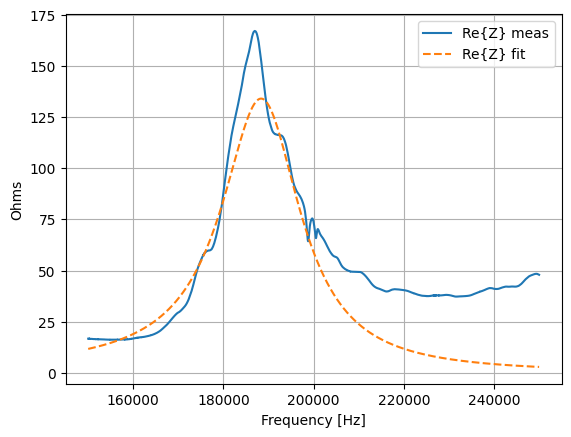

In [86]:
def model_Z(f, R1, L1, C1, C0):
    w = 2*np.pi*f
    Zs = R1 + 1j*w*L1 + 1/(1j*w*C1)
    Y = 1j*w*C0 + 1/Zs
    return 1/Y

pars = fit_C0_parallel_series_RLC(f_band, Z_meas_band)
Z_fit = model_Z(f_band, **{k:pars[k] for k in ["R1","L1","C1","C0"]})

print(R1, L1, C1, C0)

# Inspect resonance
import matplotlib.pyplot as plt
plt.figure()
plt.plot(f_band, Z_meas_band.real, label="Re{Z} meas")
plt.plot(f_band, Z_fit.real,  linestyle="--", label="Re{Z} fit")
plt.xlabel("Frequency [Hz]"); plt.ylabel("Ohms"); plt.legend(); plt.grid(True)
plt.show()


In [ ]:
import numpy as np

# --- baseline (your initial guess) ---
R1_init = 40.57352305666899
L1_init = 0.0007245967924292482
C1_init = 1e-09
C0_init = 1.38e-12

Z_init = model_Z(f_band, R1_init, L1_init, C1_init, C0_init)
rmse_init = np.sqrt(np.mean((Z_init.real - Z_meas_band.real)**2))
print("Initial guess RMSE (Re{Z}):", rmse_init)

# --- fitted (whatever your last fit returned in `pars`) ---
Z_fit = model_Z(f_band, pars["R1"], pars["L1"], pars["C1"], pars["C0"])
rmse_fit = np.sqrt(np.mean((Z_fit.real - Z_meas_band.real)**2))
print("Fitted params RMSE (Re{Z}):", rmse_fit)

print("ΔRMSE (fit - init):", rmse_fit - rmse_init)
print("Params fit:",
      "R1=",pars["R1"], "L1=",pars["L1"], "C1=",pars["C1"], "C0=",pars["C0"])


Initial guess RMSE (Re{Z}): 39.151648845934886
Fitted params RMSE (Re{Z}): 23.078609386142883
ΔRMSE (fit - init): -16.073039459792003
Params fit: R1= 680.0490371666517 L1= 0.0050916170407732855 C1= 1.466693239685707e-10 C0= 2.793708337654388e-09


Best (real-part RMSE): 36.500051286885885
R1=1000 Ω, L1=3.40648e-05 H, C1=3.18623e-10 F, C0=1e-09 F


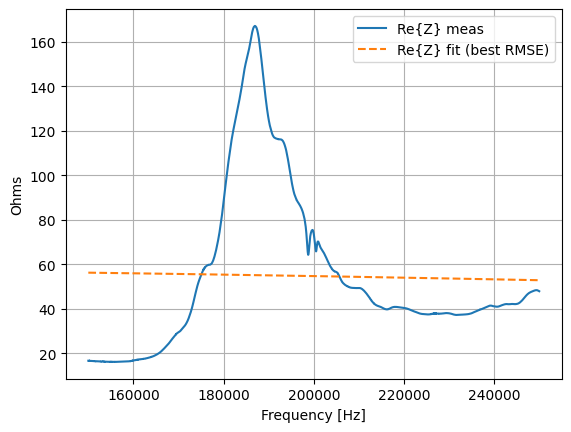

In [89]:
import numpy as np
from numpy.random import default_rng
from scipy.optimize import least_squares, differential_evolution

def real_RMSE(f, Z_meas, R1, L1, C1, C0):
    w = 2*np.pi*f
    Zs = R1 + 1j*w*L1 + 1/(1j*w*C1)
    Y = 1j*w*C0 + 1/Zs
    Z = 1/Y
    e = (Z.real - Z_meas.real)
    return np.sqrt(np.mean(e*e))

def fit_real_only(f, Z_meas, seeds=None, bounds=None, n_random=200, use_de=True, logparam=True):
    # Bounds (tighten/loosen as needed)
    if bounds is None:
        lo = np.array([1e-2, 1e-8, 1e-12, 1e-14])   # R [Ω], L [H], C1 [F], C0 [F]
        hi = np.array([1e3,  1e-2, 1e-7,  1e-9])
        bounds = (lo, hi)
    lo, hi = bounds

    # Seed defaults (from your post)
    if seeds is None:
        seeds = np.array([40.57352305666899, 7.245967924292482e-04, 1e-9, 1.38e-12])

    def pack(x):   return np.log(x) if logparam else x
    def unpack(p): return np.exp(p) if logparam else p

    # Objective for LS (real-part only)
    w = 2*np.pi*f
    def residuals(p):
        R1, L1, C1, C0 = unpack(p)
        Zs = R1 + 1j*w*L1 + 1/(1j*w*C1)
        Y  = 1j*w*C0 + 1/Zs
        Z  = 1/Y
        return (Z.real - Z_meas.real)

    # Helper to clamp in (log) bounds
    lb = pack(lo); ub = pack(hi)
    def project(p):
        return np.minimum(ub, np.maximum(lb, p))

    # 1) Try your seed and a few scaled variants
    start_list = [seeds]
    # multiplicative perturbations (decades up/down)
    mults = [0.3, 0.5, 2.0, 3.0]
    for mR in mults:
        for mL in mults:
            for mC1 in mults:
                for mC0 in mults:
                    start_list.append(seeds * np.array([mR, mL, mC1, mC0]))

    # 2) Random log-uniform starts inside bounds
    rng = default_rng(123)
    if logparam:
        rand_ps = rng.uniform(lb, ub, size=(n_random, 4))
        rand_xs = np.exp(rand_ps)
    else:
        rand_xs = rng.uniform(lo, hi, size=(n_random, 4))
    start_list.extend(rand_xs)

    # 3) Optional global search with Differential Evolution
    best = {"rmse": np.inf, "x": None}
    if use_de:
        def de_fun(x):
            R1, L1, C1, C0 = x
            return real_RMSE(f, Z_meas, R1, L1, C1, C0)
        result = differential_evolution(
            de_fun, bounds=list(zip(lo, hi)), maxiter=200, polish=False, tol=1e-6, updating='deferred'
        )
        start_list.append(result.x)

    # 4) Local least-squares polish from every start (cheap because residuals are analytic)
    for x0 in start_list:
        p0 = pack(np.clip(x0, lo, hi))
        res = least_squares(
            residuals, project(p0), bounds=(lb, ub),
            method='trf', ftol=1e-12, xtol=1e-12, gtol=1e-12, max_nfev=2000
        )
        R1,L1,C1,C0 = unpack(res.x)
        rmse = real_RMSE(f, Z_meas, R1,L1,C1,C0)
        if rmse < best["rmse"]:
            best = {"rmse": rmse, "x": np.array([R1,L1,C1,C0]), "res": res}

    R1,L1,C1,C0 = best["x"]
    return {
        "R1": R1, "L1": L1, "C1": C1, "C0": C0,
        "rmse_real": best["rmse"],
        "res": best["res"]
    }

# ---- usage ----
best = fit_real_only(f_band, Z_meas_band)
print("Best (real-part RMSE):", best["rmse_real"])
print("R1={:.6g} Ω, L1={:.6g} H, C1={:.6g} F, C0={:.6g} F".format(best["R1"], best["L1"], best["C1"], best["C0"]))

# Compare curves
Z_fit = model_Z(f_band, best["R1"], best["L1"], best["C1"], best["C0"])
import matplotlib.pyplot as plt
plt.figure()
plt.plot(f_band, Z_meas_band.real, label="Re{Z} meas")
plt.plot(f_band, Z_fit.real,  linestyle="--", label="Re{Z} fit (best RMSE)")
plt.xlabel("Frequency [Hz]"); plt.ylabel("Ohms"); plt.legend(); plt.grid(True)
plt.show()
